## **Image Generation with Autoencoders**

#### **What is Autoencoder**
An autoencoder is a type of artificial neural network used to learn efficient codings of unlabeled data (unsupervised learning). The encoding is validated and refined by attempting to regenerate the input from the encoding. The autoencoder learns a representation (encoding) for a set of data, typically for dimensionality reduction, by training the network to ignore insignificant data (“noise”).[1]<br/>
<img src="https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png"><br/>
A typical autoencoder consist of three parts, an encoder, a latent space representation, and a decoder. The input image is first projected into the latent space by encoding layers of the network resulting in a latent space in a lower dimension than the original image. This latent space is then used by the decoding layers of the network to reconstruct the original image. <br/><br/>
Here we using 94_character_TMNIST dataset to make experiment with autoencoder and find how tunning latent space and network architecture to gives the best trade-off between compression and quality.
#### **Import libraries and data preparation**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.initializers import *
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df=pd.read_csv('94_character_TMNIST.csv')
df.head()

,names,labels,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,784
0,Salsa-Regular,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MouseMemoirs-Regular,D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Creepster-Regular,f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,SeoulNamsan-Light,/,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,HachiMaruPop-Regular,F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#get independent variable and response variable
X = df.drop(columns=['names','labels'])
y = df[['labels']]
#preping the data to create dictionary
labels = y['labels'].unique()
values = [num for num in range(len(df['labels'].unique()))]
label_dict= dict(zip(labels,values)) #Creating Dictionary 
label_dict_inv = dict(zip(values,labels))
y['labels'].replace(label_dict, inplace=True) #Maping Values avaliable for later traning

#splitiing the data into test and train
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42,stratify=y)
#the pixel values are from 0-255, for neural network models we are squishing them between 0-1 
X_train= (X_train.astype('float32'))/255.0
X_test = (X_test.astype('float32'))/255.0
X_train=X_train.values.reshape(X_train.shape[0],28,28,1)
X_test=X_test.values.reshape(X_test.shape[0],28,28,1)
#Target into Categorical Values
NCl = y_train.nunique()[0]
y_train = to_categorical(y_train, NCl, dtype='int' )
y_test = to_categorical(y_test, NCl, dtype='int' )
print(X_train.shape)

(191865, 28, 28, 1)


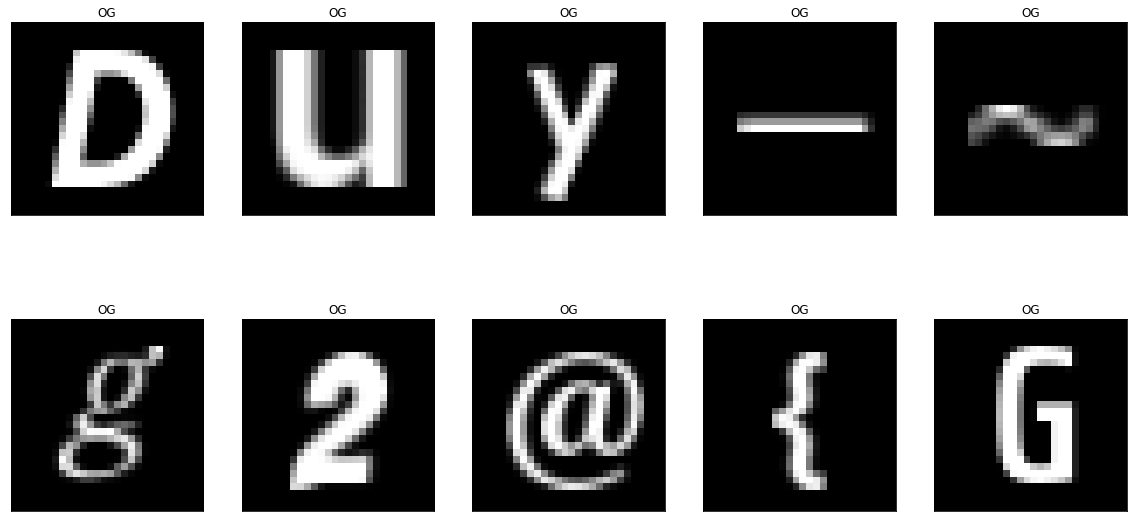

In [ ]:
n = 10
plt.figure(figsize=(20, 10))
for i in range(n):
  # display original
  ax = plt.subplot(2, 5, i + 1)
  plt.imshow(np.reshape(X_test[i], (28, 28)), cmap = 'Greys')
  plt.title("OG")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

#### **Build Autoencoder and training**
I chose a autoencoder with 9 layers as baseline. First compress the input to 3 latent space size and using relu as activation function.<br>
Then we adjust size of latent space to 16 and other network architecture and parameters/environments keep same as baseline.


In [ ]:
input_layer = Input(shape=(28,28,1))

## encoding architecture
encode_layer1 = Conv2D(128, (3, 3), activation='relu', padding='same')(input_layer)
encode_layer2 = MaxPooling2D((2, 2), padding='same')(encode_layer1)
## latent space size 3
latent_view   = Conv2D(3, (3, 3), activation='relu', padding='same')(encode_layer2)
latent_view   = MaxPooling2D((2, 2), padding='same')(latent_view)
## decoding architecture
decode_layer1 = Conv2D(3, (3, 3), activation='relu', padding='same')(latent_view)
decode_layer2 = UpSampling2D((2, 2))(decode_layer1)
decode_layer3 = Conv2D(128, (3, 3), activation='relu', padding='same')(decode_layer2)
decode_layer4 = UpSampling2D((2, 2))(decode_layer3)

## output layer
output_layer  = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decode_layer4)

model = Model(input_layer, output_layer)
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy')
model.fit(X_train, X_train,
                epochs=20,batch_size=255,
                validation_data=(X_test, X_test),verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 3)         3459      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 3)          0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 3)           84    

##### **Adjust latent space size**
Adjusting latent space size to 16.

In [ ]:
## encoding architecture
encode_layer1 = Conv2D(128, (3, 3), activation='relu', padding='same')(input_layer)
encode_layer2 = MaxPooling2D((2, 2), padding='same')(encode_layer1)

## latent space size increase to 16
latent_view   = Conv2D(16, (3, 3), activation='relu', padding='same')(encode_layer2)
latent_view   = MaxPooling2D((2, 2), padding='same')(latent_view)
## decoding architecture
decode_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decode_layer2 = UpSampling2D((2, 2))(decode_layer1)
decode_layer3 = Conv2D(128, (3, 3), activation='relu', padding='same')(decode_layer2)
decode_layer4 = UpSampling2D((2, 2))(decode_layer3)

## output layer
output_layer  = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decode_layer4)

model1 = Model(input_layer, output_layer)
model1.summary()

model1.compile(optimizer='adam', loss='binary_crossentropy')
model1.fit(X_train, X_train,
                epochs=20,batch_size=255,
                validation_data=(X_test, X_test),verbose=1)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 128)       1280      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 16)        18448     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 16)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 16)          2320

##### **Modifiy network architecture**
updating layers to 2 conv2d and maxpooling layers and conv2d layers with 128 and 64 filters.

In [ ]:
## encoding architecture 3 conv2d and 3 maxpooling layers
encode_layer1 = Conv2D(128, (3, 3), activation='relu', padding='same')(input_layer)
encode_layer2 = MaxPooling2D((2, 2), padding='same')(encode_layer1)
encode_layer3 = Conv2D(64, (3, 3), activation='relu', padding='same')(encode_layer2)
encode_layer4 = MaxPooling2D((2, 2), padding='same')(encode_layer3)

## latent space size decrease to 16
encode_layer5   = Conv2D(16, (3, 3), activation='relu', padding='same')(encode_layer4)
latent_view   = MaxPooling2D((1, 1), padding='same')(encode_layer5)
## decoding architecture
decode_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decode_layer2 = UpSampling2D((1, 1))(decode_layer1)
decode_layer3 = Conv2D(64, (3, 3), activation='relu', padding='same')(decode_layer2)
decode_layer4 = UpSampling2D((2, 2))(decode_layer3)
decode_layer5 = Conv2D(128, (3, 3), activation='relu', padding='same')(decode_layer4)
decode_layer6 = UpSampling2D((2, 2))(decode_layer5)

## output layer
output_layer  = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decode_layer6)

model2 = Model(input_layer, output_layer)
model2.summary()

model2.compile(optimizer='adam', loss='binary_crossentropy')
model2.fit(X_train, X_train,
                epochs=20,batch_size=255,
                validation_data=(X_test, X_test),verbose=1)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_29 (Conv2D)          (None, 28, 28, 128)       1280      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 14, 14, 64)        73792     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 7, 7, 16)          9232

##### Observe reconstructed fake image of above autoencoders

2570/2570 [==============================] - 5s 2ms/step


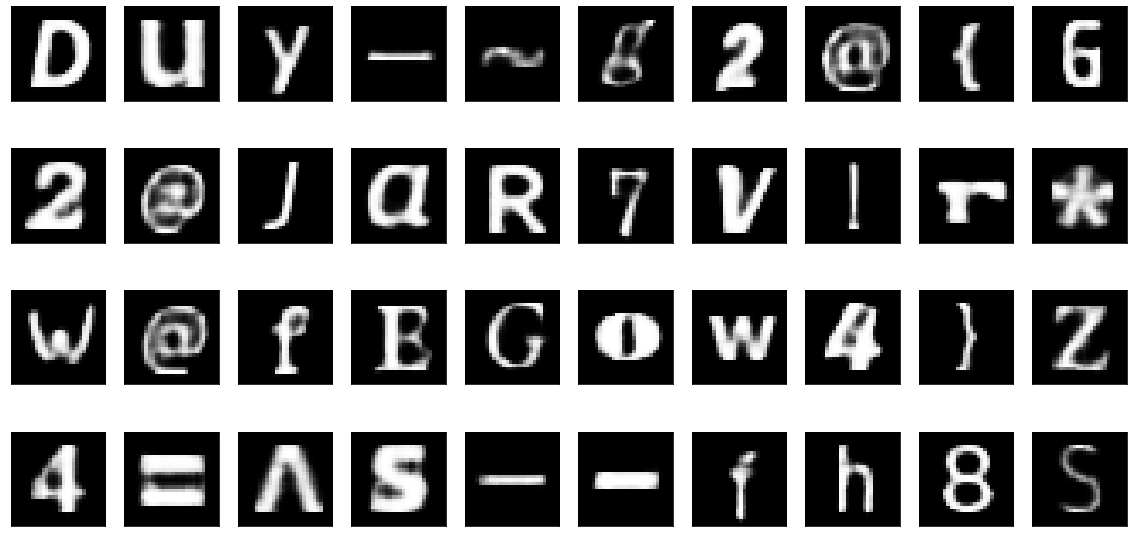

In [ ]:
# display fake img of autoencoder with a latent size of 3
decoded_imgs = model.predict(X_test)
plt.figure(figsize=(20, 10))
for i in range(40):
  # display original
  ax = plt.subplot(4, 10, i + 1)
  plt.imshow(np.reshape(decoded_imgs[i], (28, 28)))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()


2570/2570 [==============================] - 5s 2ms/step


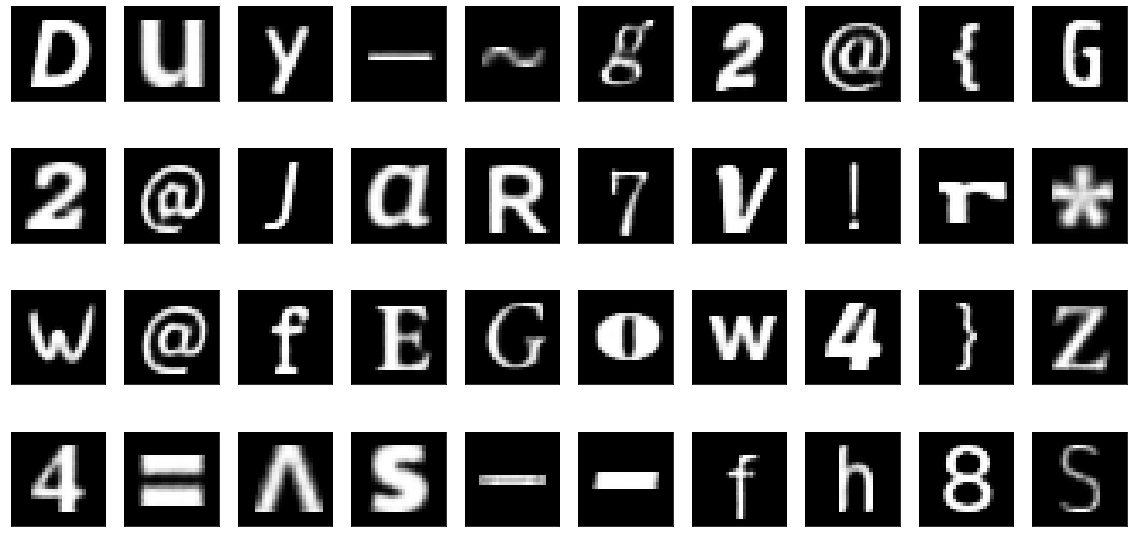

In [ ]:
 # display fake img of autoencoder with a latent size of 16
decoded_imgs1 = model1.predict(X_test)
plt.figure(figsize=(20, 10))
for i in range(40):
 
  ax = plt.subplot(4, 10, i + 1)
  ax.imshow(np.reshape(decoded_imgs1[i], (28, 28)))
  #plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()


2570/2570 [==============================] - 6s 2ms/step


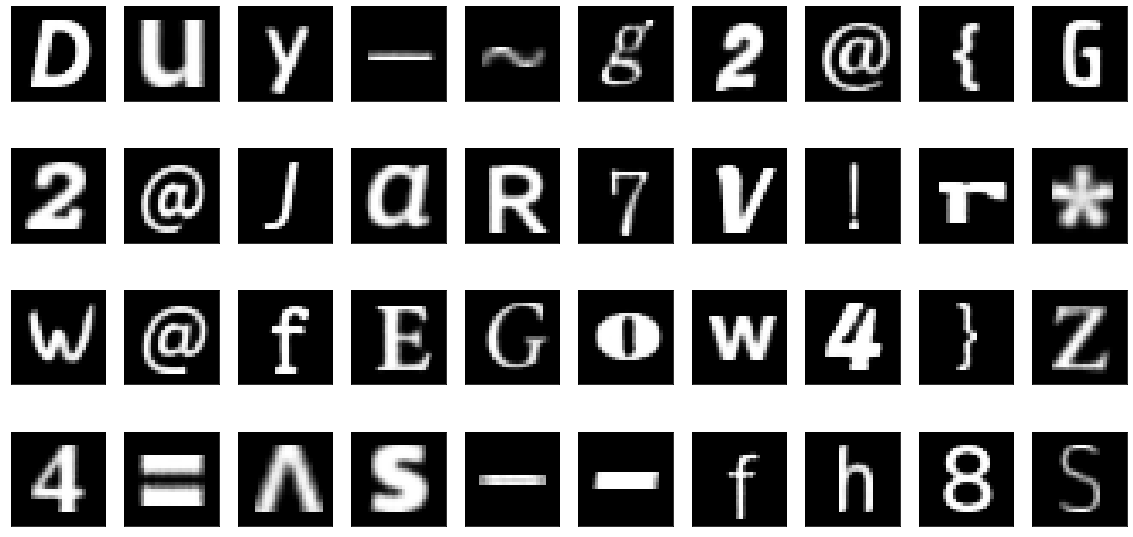

In [ ]:
 # display fake img of autoencoder with a latent size of 16 and 13 layers
decoded_imgs2 = model2.predict(X_test)
plt.figure(figsize=(20, 10))
for i in range(40):
 
  ax = plt.subplot(4, 10, i + 1)
  ax.imshow(np.reshape(decoded_imgs2[i], (28, 28)))
  #plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

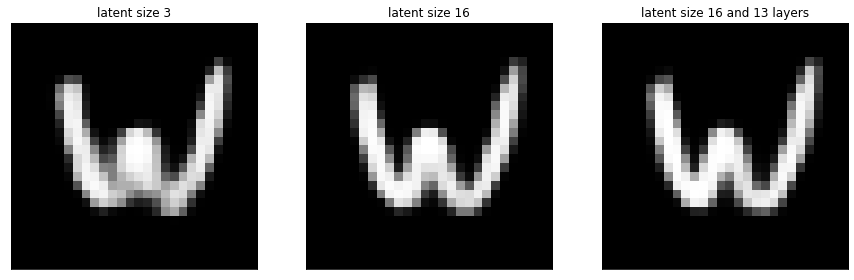

In [ ]:
plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 3, 1)
plt.title('latent size 3')
plt.imshow(np.reshape(decoded_imgs[20], (28, 28)))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = plt.subplot(1, 3, 2)
plt.title('latent size 16')
plt.imshow(np.reshape(decoded_imgs1[20], (28, 28)))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = plt.subplot(1, 3, 3)
plt.title('latent size 16 and 13 layers')
plt.imshow(np.reshape(decoded_imgs2[20], (28, 28)))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

From above reconstructed image, we can assume that autoencoder with 9 layers and a latent space size of 16 can give a better trade-off between compression and quality than autoencoder with latent space size of 3. After change the network architecture to 3 conv2d and 3 maxpooling in encoder and decoder, also make latent space size be 16, the quality of fake image is better than baseline.

#### **Conclusion**
From above experiments, we can assumed that autoencoder with 13 layers and a latent space size of 16 gives the better trade-off between compression and quality than other conditions in above experiments.

#### **Reference**
[1] https://en.wikipedia.org/wiki/Autoencoder<br/>
[2] https://www.kaggle.com/code/shivamb/how-autoencoders-work-intro-and-usecases/notebook<br/>

#### **License**

MIT License

Copyright (c) 2022 Yanping Fu

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.